In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import base_import as bi

import pandas as pd
import numpy as np
import joblib

from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, BatchNormalization, GaussianNoise, Conv1D, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from numpy.random import seed
import tensorflow as tf

In [3]:
tf.random.set_seed(42)
seed(42)

# 정상 데이터

In [16]:
# df_binign = bi.DATASETS("../csv/pure.csv")

part_pure = pd.read_csv('../csv/Pure_MDPII.csv') # Parkhyosung, hyoseong
df_benign = pd.DataFrame(data = part_pure)

In [17]:
df_benign

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,6,15/02/2018 09:33:53,403,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,53,17,22/02/2018 01:51:17,210786,2,2,76,262,38,38,...,8,0.0,0.0,0,0,0.0,0.0,0,0,0
2,443,6,15/02/2018 11:02:37,60587301,13,16,592,5541,205,0,...,20,160621.0,0.0,160621,160621,58406313.0,0.0,58406313,58406313,0
3,45028,6,16/02/2018 01:45:50,4980600,5,3,935,370,935,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
4,56330,6,16/02/2018 01:46:27,4034259,5,3,935,338,935,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99949,3389,6,14/02/2018 08:30:28,2327193,8,7,1138,1581,677,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
99950,53,17,23/02/2018 10:04:14,1816,1,1,33,150,33,33,...,8,0.0,0.0,0,0,0.0,0.0,0,0,0
99951,49168,6,23/02/2018 01:50:47,86257263,2,0,0,0,0,0,...,20,0.0,0.0,0,0,86257263.0,0.0,86257263,86257263,0
99952,50851,6,23/02/2018 11:01:03,12,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [18]:
try:
    df_benign.index = pd.to_datetime(df_benign['Timestamp'], format='%d/%m/%Y %H:%M:%S')
    print("형식 1로 변환 성공")
except ValueError:
    # 첫 번째 형식이 실패하면 두 번째 형식으로 변환
    print("형식 1 실패, 형식 2로 변환 시도")
    df_benign.index = pd.to_datetime(df_benign['Timestamp'], format='%m-%d-%y %H:%M')
except ValueError:
    # 첫 번째 형식이 실패하면 두 번째 형식으로 변환
    print("형식 2 실패, 형식 3로 변환 시도")
    df_benign.index = pd.to_datetime(df_benign['Timestamp'], format='%m-%d-%y %H:%M:%S')
    
# 형식이 변환되었으면 원하는 형식으로 다시 변환
df_benign.index = df_benign.index.strftime('%d/%m/%Y %H:%M:%S')

# 인덱스를 기준으로 정렬
df_benign = df_benign.sort_index()


형식 1로 변환 성공


In [19]:
print(df_benign['Timestamp'].value_counts)
df_benign['Timestamp'] = np.nan
df_benign = df_benign.dropna(axis=1)

<bound method IndexOpsMixin.value_counts of Timestamp
01/05/1970 03:01:17    01/05/1970 03:01:17
03/01/2018 01:00:06    03/01/2018 01:00:06
03/01/2018 01:00:28    03/01/2018 01:00:28
03/01/2018 01:00:40    03/01/2018 01:00:40
03/01/2018 01:00:43    03/01/2018 01:00:43
                              ...         
28/02/2018 12:59:16    28/02/2018 12:59:16
28/02/2018 12:59:24    28/02/2018 12:59:24
28/02/2018 12:59:25    28/02/2018 12:59:25
28/02/2018 12:59:29    28/02/2018 12:59:29
28/02/2018 12:59:36    28/02/2018 12:59:36
Name: Timestamp, Length: 99954, dtype: object>


In [20]:
df_benign

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
Timestamp,,,,,,,,,,,,,,,,,,,,,
01/05/1970 03:01:17,0,0,-11873000000,2,0,0,0,0,0,0.000,...,0,0.00000,0.000000,0,0,0.0,0.000000,0,0,0
03/01/2018 01:00:06,53,17,1450,1,1,78,158,78,78,78.000,...,8,0.00000,0.000000,0,0,0.0,0.000000,0,0,0
03/01/2018 01:00:28,445,6,281850,3,1,0,0,0,0,0.000,...,20,0.00000,0.000000,0,0,0.0,0.000000,0,0,0
03/01/2018 01:00:40,53,17,83469,2,2,86,198,43,43,43.000,...,8,0.00000,0.000000,0,0,0.0,0.000000,0,0,0
03/01/2018 01:00:43,80,6,115911693,16,15,442,1950,431,0,27.625,...,20,33502.81818,9428.623111,61931,30624,10000000.0,6310.941709,10000000,10000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28/02/2018 12:59:16,61368,6,46,2,0,0,0,0,0,0.000,...,20,0.00000,0.000000,0,0,0.0,0.000000,0,0,0
28/02/2018 12:59:24,58617,6,147730,2,1,0,0,0,0,0.000,...,20,0.00000,0.000000,0,0,0.0,0.000000,0,0,0
28/02/2018 12:59:25,3389,6,3071872,4,2,0,0,0,0,0.000,...,20,0.00000,0.000000,0,0,0.0,0.000000,0,0,0


In [21]:
#label mappings
label_mapping = df_benign['Label'].values
unique_val = np.array(label_mapping)
tmp_df = df_benign.copy()
labelencoder = LabelEncoder()
tmp_df.iloc[:,-1] = labelencoder.fit_transform(df_benign.iloc[:,-1])

In [22]:
# feature engineering
tmp_df = bi.Auto_Feature_Engineering(tmp_df)
df_benign1 = df_benign

          feature  normalized_importance  cumulative_importance
0        Dst Port                    NaN                    NaN
1        Protocol                    NaN                    NaN
2   Flow Duration                    NaN                    NaN
3    Tot Fwd Pkts                    NaN                    NaN
4    Tot Bwd Pkts                    NaN                    NaN
..            ...                    ...                    ...
67     Active Min                    NaN                    NaN
68      Idle Mean                    NaN                    NaN
69       Idle Std                    NaN                    NaN
70       Idle Max                    NaN                    NaN
71       Idle Min                    NaN                    NaN

[72 rows x 3 columns]
       drop_feature     corr_feature  corr_value
0   TotLen Bwd Pkts     Tot Bwd Pkts    0.998910
1   Fwd Pkt Len Std  Fwd Pkt Len Max    0.969886
2   Bwd Pkt Len Std  Bwd Pkt Len Max    0.964514
3      Flow I

c:\Users\Parkhyosung\iCloudDrive\대학원\대학원 업무\ML\model\base_import.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  record_collinear = pd.concat([record_collinear, temp_df], ignore_index=True)


In [23]:
# bi.DATASETS().setDF(tmp_df)
df_benign = tmp_df
indices_to_keep = ~df_benign.isin([np.nan, np.inf, -np.inf]).any(axis=1)
df_benign = df_benign[indices_to_keep]

In [24]:
train, test = train_test_split(df_benign, train_size=0.7, test_size=0.3, random_state=42)

print("train_benign data shape :", train.shape)
print(" test_benign data shape :", test.shape)

train_benign data shape : (69967, 42)
 test_benign data shape : (29987, 42)


In [ ]:
corr_matrix = df_benign.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

In [25]:
#BENIGN
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
sclaer_fn = "scaler_Data"
joblib.dump(scaler, sclaer_fn)

['scaler_Data']

In [26]:
# reshape inputs for LSTM [samples, timesteps, features] BENIGN
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)


Training data shape: (69967, 1, 42)
Test data shape: (29987, 1, 42)


In [27]:
def CNNBILSTM_model(X):
    model = Sequential([
        # Input layer
        Conv1D(128, 1, activation='relu', padding='same', input_shape=(X.shape[1], X.shape[2])),
        BatchNormalization(),
        
        # Encoder
        Bidirectional(LSTM(256, return_sequences=True)),
        Bidirectional(LSTM(128)),
        Dropout(0.1),
        
        # Bottleneck
        Dense(64, activation='relu'),
        
        # Decoder
        RepeatVector(1),
        Bidirectional(LSTM(128, return_sequences=True)),

        Dropout(0.1),
        Bidirectional(LSTM(256, return_sequences=True)),
        
        Conv1D(128, 1, activation='relu', padding='same'),
        # Output layer
        TimeDistributed(Dense(X.shape[2], activation='tanh'))
    ])
    
    return model



# Benign Data 학습

In [28]:
# 모델 만들어
model = CNNBILSTM_model(X_train)
mae = MeanAbsoluteError()
model.compile(optimizer='adam', loss='mae', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.summary()

c:\Users\Parkhyosung\miniconda3\envs\hyo\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 128)         │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 512)         │       788,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 1, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 1, 512)         │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 128)         │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 42)          │         5,418 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,786,666 (10.63 MB)

 Trainable params: 2,786,410 (10.63 MB)

 Non-trainable params: 256 (1.00 KB)

In [29]:
# Benign 데이터에 fit 시켜
nb_epochs = 10
batch_size = 128
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.1).history

Epoch 1/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0514 - mean_absolute_error: 0.0514 - val_loss: 0.0176 - val_mean_absolute_error: 0.0176
Epoch 2/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0165 - mean_absolute_error: 0.0165 - val_loss: 0.0121 - val_mean_absolute_error: 0.0121
Epoch 3/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0111 - val_mean_absolute_error: 0.0111
Epoch 4/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0112 - mean_absolute_error: 0.0112 - val_loss: 0.0098 - val_mean_absolute_error: 0.0098
Epoch 5/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0090 - val_mean_absolute_error: 0.0090
Epoch 6/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0077 - val_mean_absolute_error: 0.0077
Epoch 7/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0080 - mean_absolute_error: 0.

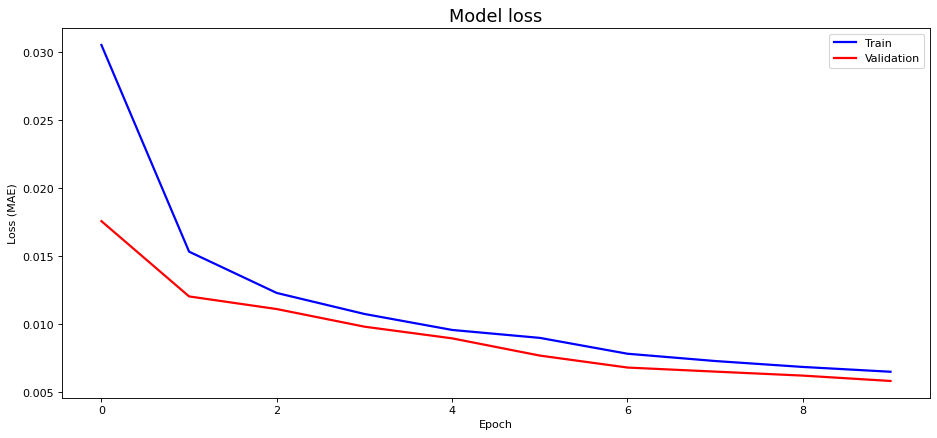

In [30]:
# Benign 데이터에 대한 loss 현황 보여줘

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


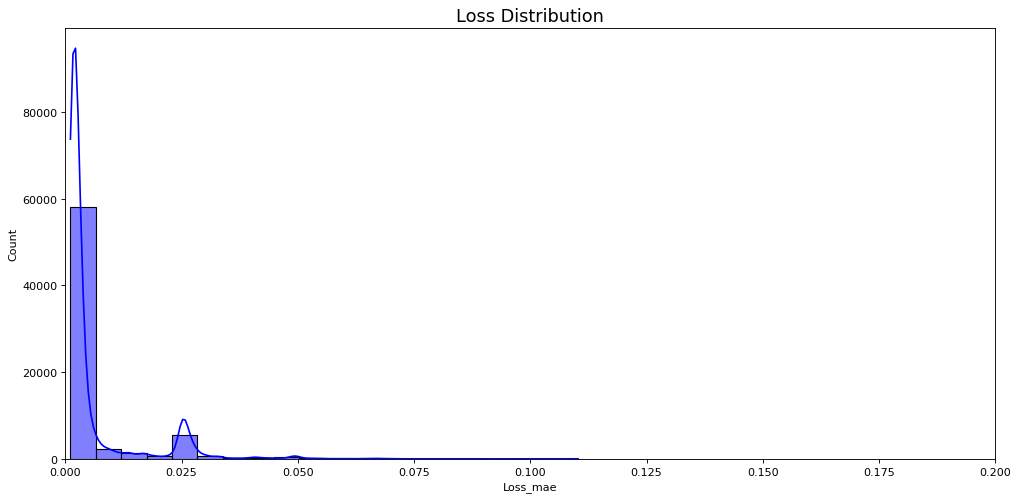

In [31]:
# 훈련 세트에 대한 loss 분포도.

Xtrain_pred = model.predict(X_train)
Xtrain_pred = Xtrain_pred.reshape(Xtrain_pred.shape[0], Xtrain_pred.shape[2])
Xtrain_pred = pd.DataFrame(Xtrain_pred, columns=train.columns)
Xtrain_pred.index = train.index

scoredTrain = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scoredTrain['Loss_mae'] = np.mean(np.abs(Xtrain_pred-Xtrain), axis=1)# np.mean(np.square(X_pred-Xtrain), axis=1)

plt.figure(figsize=(15, 7), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(scoredTrain['Loss_mae'], bins=20, kde=True, color='blue')
plt.xlim([0.0, 0.2])
plt.show()

In [32]:
# 테스트 셋의 로스 계산

Xtest_pred = model.predict(X_test)
Xtest_pred = Xtest_pred.reshape(Xtest_pred.shape[0], Xtest_pred.shape[2])
Xtest_pred = pd.DataFrame(Xtest_pred, columns=test.columns)
Xtest_pred.index = test.index

scoredTest = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
# scored['Loss_mse'] = np.mean(np.abs(X_pred-Xtest), axis = 1) 
scoredTest['Loss_mae'] = np.mean(np.abs(Xtest_pred - Xtest), axis=1) # np.mean(np.square(X_pred - Xtest), axis=1)
scoredTest['Threshold'] = np.percentile(scoredTest['Loss_mae'], 85) 
scoredTest['Anomaly'] = scoredTest['Loss_mae'] > scoredTest['Threshold']
scoredTest.head()

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


,Loss_mae,Threshold,Anomaly
Timestamp,,,
03/02/2018 08:46:50,0.001560,0.009365,False
15/02/2018 11:06:54,0.001418,0.009365,False
23/02/2018 08:24:57,0.001664,0.009365,False
15/02/2018 11:37:56,0.001465,0.009365,False
22/02/2018 10:05:40,0.030878,0.009365,True


In [33]:
# 훈련 세트에 대해 동일한 메트릭 계산
# 그리고 플롯을 위해 모든 데이터를 단일 데이터 프레임에 병합

X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
# scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-scored_train), axis = 1) # np.mean(np.square(X_pred_train-scored_train), axis = 1)
# scored_train['Threshold'] = np.percentile(scored_train['Loss_mae'], 90) 
# scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scoredTest])

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


<Axes: xlabel='Timestamp'>

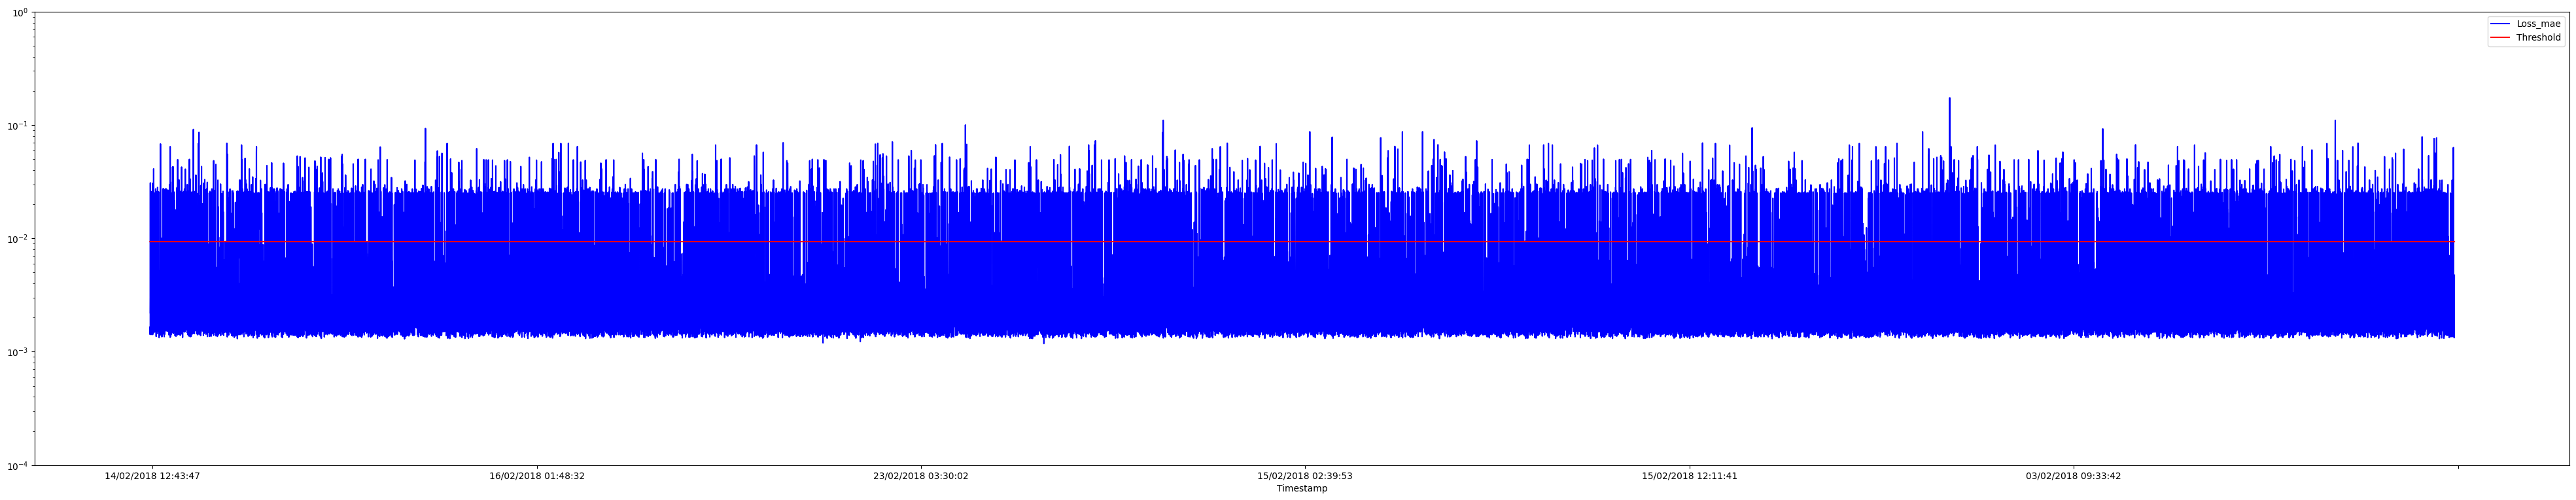

In [34]:
# 임계치를 넘었는지 표로 표현
scored.plot(logy=True,  figsize=(50,9), ylim=[1e-4,1], color=['blue','red'])

# 스케일러 및 모델 저장

In [35]:
scaler_fn = "./CNN/CNNBILSTM_MDPI.pkl"
joblib.dump(scaler, scaler_fn)

['./CNN/CNNBILSTM_MDPI.pkl']

In [42]:
# save all model information, including weights, in h5 format
tf.keras.models.save_model(model, "./CNN/CNNBILSTM_MDPI.keras")
# tf.keras.models.save_model(model, "./CNN/Benign_model.keras")
print("Model saved")

Model saved


In [43]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

In [44]:
# 모델 로드
# model = load_model('CNN/CNNBILSTM_benign_model_1.h5')
model = load_model('CNN/CNNBILSTM_MDPI.keras', custom_objects={'mae': 'mean_absolute_error'})

c:\Users\Parkhyosung\miniconda3\envs\hyo\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 70 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [39]:
# 모델 구조 시각화
plot_model(model, to_file='./CNN/model_sero.png', show_shapes=False, show_layer_names=True)#, rankdir='LR')

You must install pydot (`pip install pydot`) for `plot_model` to work.


# 혼합 데이터 준비

In [45]:
from tensorflow.keras.models import load_model

# h5 파일에서 모델 불러오기
loaded_model = load_model('CNN/CNNBILSTM_MDPI.keras') #hyoseong Parkhyosung
# loaded_model = tf.keras.models.load_model("Benign_model.keras", custom_objects={'MeanAbsoluteError': MeanAbsoluteError})
# 학습된 스케일러 불러오기
load_scaler = joblib.load("./CNN/CNNBILSTM_MDPI.pkl")

In [61]:
part = pd.read_csv('../csv/Mixed_MDPI.csv') #hyoseong
df_mix = pd.DataFrame(data=part)

In [62]:
try:
    df_mix.index = pd.to_datetime(df_mix['Timestamp'], format='%d/%m/%Y %H:%M:%S')
    print("형식 1로 변환 성공")
except ValueError:
    # 첫 번째 형식이 실패하면 두 번째 형식으로 변환
    print("형식 1 실패, 형식 2로 변환 시도")
    df_mix.index = pd.to_datetime(df_mix['Timestamp'], format='%m-%d-%y %H:%M')
except ValueError:
    # 첫 번째 형식이 실패하면 두 번째 형식으로 변환
    print("형식 2 실패, 형식 3로 변환 시도")
    df_mix.index = pd.to_datetime(df_mix['Timestamp'], format='%m-%d-%y %H:%M:%S')
    
# 형식이 변환되었으면 원하는 형식으로 다시 변환
df_mix.index = df_mix.index.strftime('%d/%m/%Y %H:%M:%S')

형식 1로 변환 성공


In [63]:
print(df_mix['Timestamp'].value_counts)
df_mix['Timestamp'] = np.nan
df_mix = df_mix.dropna(axis=1)

<bound method IndexOpsMixin.value_counts of Timestamp
14/02/2018 11:53:09    14/02/2018 11:53:09
28/02/2018 01:59:45    28/02/2018 01:59:45
15/02/2018 09:52:12    15/02/2018 09:52:12
28/02/2018 01:29:33    28/02/2018 01:29:33
15/02/2018 09:30:22    15/02/2018 09:30:22
                              ...         
23/02/2018 04:08:24    23/02/2018 04:08:24
14/02/2018 02:03:09    14/02/2018 02:03:09
23/02/2018 08:24:03    23/02/2018 08:24:03
21/02/2018 02:31:29    21/02/2018 02:31:29
21/02/2018 02:23:48    21/02/2018 02:23:48
Name: Timestamp, Length: 100004, dtype: object>


In [64]:
#label mappings 다중 분류
# label_mapping = df_mix['Label'].values
# unique_val = np.array(label_mapping)
# tmp_df_mix = df_mix.copy()
# labelencoder = LabelEncoder()
# tmp_df_mix.iloc[:,-1] = labelencoder.fit_transform(df_mix.iloc[:,-1])

In [65]:
#label mappings 이진 분류

label_mapping = df_mix['Label'].values
unique_val = np.array(label_mapping)
tmp_df_mix = df_mix.copy()
df_mix['Label'] = df_mix['Label'].apply(lambda x: 0 if x == 'Benign' else 1)
tmp_df_mix.iloc[:,-1] = labelencoder.fit_transform(df_mix.iloc[:,-1])

In [66]:
df_mix1 = df_mix

In [67]:
# feature engineering
# tmp_df = bi.Auto_Feature_Engineering(tmp_df_mix)

# benign이랑 mix랑 컬럼이 안맞네 ㅋ

In [68]:
# df_mix = tmp_df
indices_to_keep = ~df_mix.isin([np.nan, np.inf, -np.inf]).any(axis=1)
# indices_to_keep --> benign이랑 컬럼 개수는 맞춰야겠지~

label_df = df_mix[indices_to_keep]

In [69]:
df_mix['Label'].value_counts()

Label
1    50004
0    50000
Name: count, dtype: int64

In [70]:
indices_to_keep1 = ~df_mix.isin([np.nan, np.inf, -np.inf]).any(axis=1)

In [71]:
df_mix = tmp_df_mix[df_benign.columns]

In [72]:
# 새로운 데이터에 대한 전처리
# NaN, inf, -inf 값을 0으로 대체
df_mix = df_mix.replace([np.inf, -np.inf, np.nan], 0)
features_without_label = [col for col in df_mix.columns if col != 'label']
X_scaled = load_scaler.transform(df_mix[features_without_label])
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

C:\Users\Parkhyosung\AppData\Local\Temp\ipykernel_2036\2479052045.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mix = df_mix.replace([np.inf, -np.inf, np.nan], 0)


# 혼합 데이터(이상 탐지를 위한 데이터, test_set)를 위한 이전 학습 모델 불러오기

In [73]:
# 새로운 데이터에 대한 예측 결과 계산
Mix_pred = loaded_model.predict(X_scaled)

3126/3126 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [74]:
y = df_mix['Label']

In [75]:
print(X_scaled.shape)
print(y.shape)

(100004, 1, 42)
(100004,)


In [76]:
# 새로운 데이터에 대한 재구성 손실 계산
batch_size = 1000
losses = []

for i in range(0, X_scaled.shape[0], batch_size):
    batch_X_scaled = X_scaled[i:i + batch_size]
    
    batch_pred = loaded_model.predict(batch_X_scaled)
    batch_loss = np.mean(np.abs(batch_pred - batch_X_scaled), axis=(1, 2))
    losses.extend(batch_loss)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━

# 임계치 계산

In [77]:
# ROC 커브

from sklearn.metrics import roc_curve, auc

# y: 실제 레이블 (정상=0, 공격=1)
# losses: AE의 재구성 오류 값
fpr, tpr, thresholds = roc_curve(y, losses)

# Youden's Index를 사용한 최적 임계값
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold_ROC = thresholds[optimal_idx]

print("최적의 임계값:", optimal_threshold_ROC)

최적의 임계값: 0.027785458714959965


In [78]:
# Precision - Recall 비교

from sklearn.metrics import precision_recall_curve, f1_score

# Precision-Recall 곡선 계산
precision, recall, thresholds = precision_recall_curve(y, losses)

# F1-score 계산
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # 분모가 0이 되는 것을 방지
optimal_idx = f1_scores.argmax()
optimal_threshold_PreRecall = thresholds[optimal_idx]

print("최적의 임계값:", optimal_threshold_PreRecall)


최적의 임계값: 0.027678971872706


# 결과값 비교

In [79]:
# 결과를 저장할 DataFrame 생성
scored_result = pd.DataFrame(index=df_mix.index)
scored_result['Loss_mae'] = losses

# 이상치 감지를 위한 임계값 설정
threshold = optimal_threshold_ROC
# threshold = np.linspace(optimal_threshold_ROC * 0.5, optimal_threshold_ROC * 2, 20)

# 임계값 기준으로 이상치 레이블 생성
scored_result['Anomaly'] = scored_result['Loss_mae'] > threshold
scored_result['Label'] = scored_result['Anomaly'].astype(int)

In [80]:
import numpy as np
from sklearn.metrics import f1_score

# threshold 값의 범위 설정
thresholds = np.linspace(optimal_threshold_ROC * 0.1, optimal_threshold_ROC * 2, 20000)

# 최고 점수를 저장할 변수 초기화
best_matches = 0
best_threshold_matches = 0
best_f1 = 0
best_threshold_f1 = 0

for threshold in thresholds:
    scored_result['Anomaly'] = scored_result['Loss_mae'] > threshold
    
    if len(scored_result['Anomaly']) == len(y):
        predictions = scored_result['Anomaly'].astype(int).values
        matches = (predictions == y)
        count = matches.sum()
        f1 = f1_score(y, predictions)
        
        print(f"Threshold: {threshold:.8f}, Number of matches: {count}, F1 Score: {f1:.4f}")
        
        # 최고 matches 개수 업데이트
        if count > best_matches:
            best_matches = count
            best_threshold_matches = threshold
        
        # 최고 F1 점수 업데이트
        if f1 > best_f1:
            best_f1 = f1
            best_threshold_f1 = threshold
    else:
        print("Lengths of 'scored[Anomaly]' and 'y' do not match.")

# 최고 점수 출력
print("\nBest scores:")
print(f"Best Matches: {best_matches} at threshold {best_threshold_matches:.4f}")
print(f"Best F1 Score: {best_f1:.4f} at threshold {best_threshold_f1:.4f}")


Threshold: 0.00277855, Number of matches: 81054, F1 Score: 0.8407
Threshold: 0.00278119, Number of matches: 81084, F1 Score: 0.8409
Threshold: 0.00278383, Number of matches: 81107, F1 Score: 0.8411
Threshold: 0.00278647, Number of matches: 81148, F1 Score: 0.8414
Threshold: 0.00278910, Number of matches: 81183, F1 Score: 0.8416
Threshold: 0.00279174, Number of matches: 81209, F1 Score: 0.8418
Threshold: 0.00279438, Number of matches: 81244, F1 Score: 0.8420
Threshold: 0.00279702, Number of matches: 81275, F1 Score: 0.8423
Threshold: 0.00279966, Number of matches: 81303, F1 Score: 0.8425
Threshold: 0.00280230, Number of matches: 81327, F1 Score: 0.8426
Threshold: 0.00280494, Number of matches: 81354, F1 Score: 0.8428
Threshold: 0.00280758, Number of matches: 81387, F1 Score: 0.8431
Threshold: 0.00281022, Number of matches: 81408, F1 Score: 0.8432
Threshold: 0.00281286, Number of matches: 81444, F1 Score: 0.8435
Threshold: 0.00281550, Number of matches: 81470, F1 Score: 0.8437
Threshold:

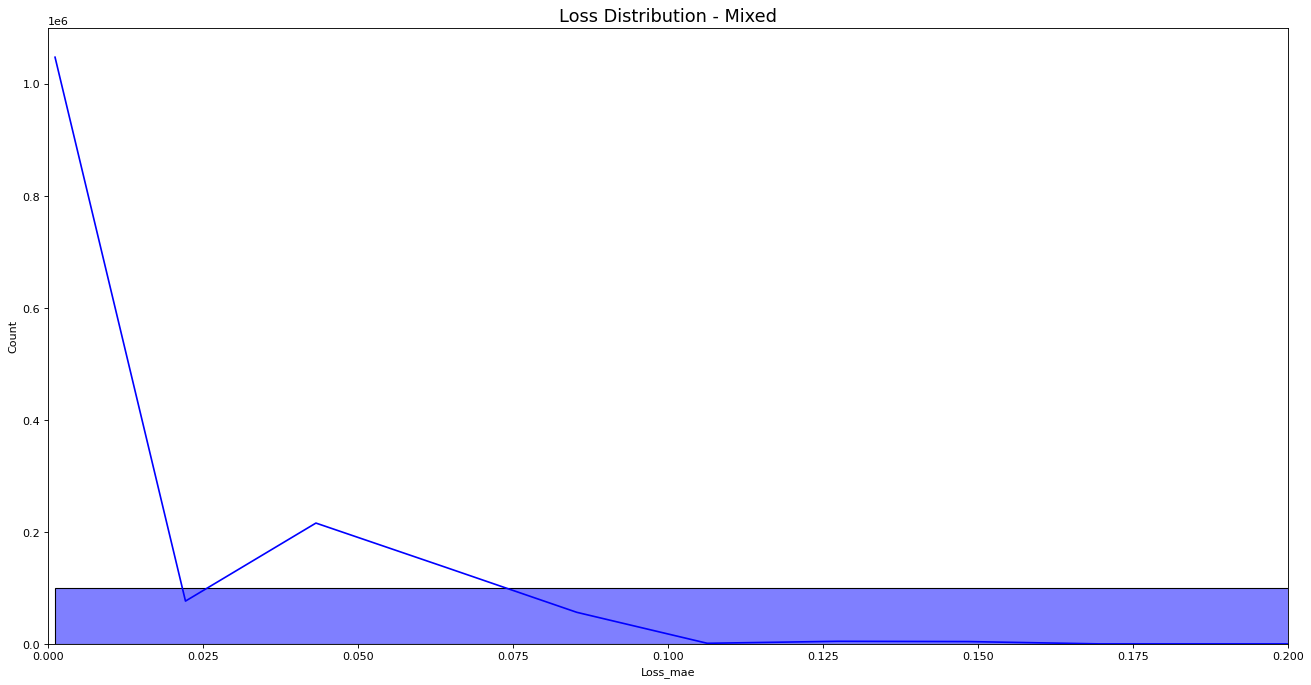

In [82]:
plt.figure(figsize=(20, 10), dpi=80)
plt.title('Loss Distribution - Mixed', fontsize=16)
sns.histplot(scored_result['Loss_mae'], bins=20, kde=True, color='blue')
plt.xlim([0.0, 0.2])
plt.show()

In [52]:
# # 테스트 세트에서 손실 계산
# X_pred = loaded_model.predict(X_scaled)
# X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])

# # X_pred를 DataFrame으로 변환
# X_pred_df = pd.DataFrame(X_pred, columns=features_without_label)  # 적절한 열 이름을 사용하세요

# # X_pred_df의 인덱스 설정
# X_pred_df.index = y.index  # y_test와 X_test가 동일한 인덱스를 가진다고 가정합니다

# # 손실 값을 저장하고 이상치를 감지하기 위한 DataFrame 생성
# scored = pd.DataFrame(index=y.index)
# X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[2])
# # 각 샘플의 재구성 손실 계산
# mae_losses = np.mean(np.abs(X_pred - X_scaled), axis=1)

# # 손실 값을 scored DataFrame에 저장
# scored['Loss_mae'] = mae_losses


# 재구성 오류 가보자고

In [83]:
scored_result

,Loss_mae,Anomaly,Label
Timestamp,,,
14/02/2018 11:53:09,0.063290,True,1
28/02/2018 01:59:45,0.028429,False,1
15/02/2018 09:52:12,0.056474,True,1
28/02/2018 01:29:33,0.001509,False,0
15/02/2018 09:30:22,0.056784,True,1
...,...,...,...
23/02/2018 04:08:24,0.002404,False,0
14/02/2018 02:03:09,0.064455,True,1
23/02/2018 08:24:03,0.001468,False,0


In [84]:
scored_result['Anomaly']=scored_result['Loss_mae'] > optimal_threshold_PreRecall + 0.00001641

In [85]:
# Mixed 데이터의 이상 탐지 결과 평가
true = y

accuracy = accuracy_score(true, scored_result['Anomaly'])
precision = precision_score(true, scored_result['Anomaly'])
recall = recall_score(true, scored_result['Anomaly'])
f1 = f1_score(true, scored_result['Anomaly'])

In [86]:
print("Mixed 데이터의 이상 탐지 결과 평가:")
print("accureacy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Mixed 데이터의 이상 탐지 결과 평가:
accureacy: 0.9831506739730411
Precision: 0.9693808163820403
Recall: 0.9978201743860491
F1 Score: 0.9833949248583395


In [87]:
conf_matrix = confusion_matrix(true, scored_result['Anomaly'])
print(conf_matrix)

[[48424  1576]
 [  109 49895]]


In [88]:
class_report = classification_report(true, scored_result['Anomaly'], zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     50000
           1       0.97      1.00      0.98     50004

    accuracy                           0.98    100004
   macro avg       0.98      0.98      0.98    100004
weighted avg       0.98      0.98      0.98    100004



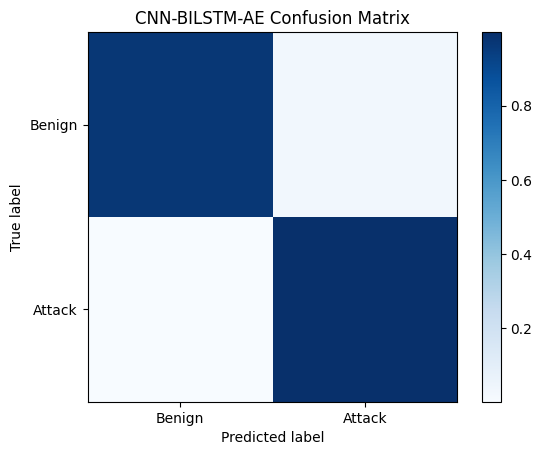

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 1. 기본 혼동 행렬 계산
cm = conf_matrix

# 2. 행 기준 정규화 (각 행을 행의 합으로 나눔)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. 정규화된 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(
    cm_normalized, 
    display_labels=["Benign", "Attack"]
)
disp.plot(
    cmap="Blues", 
    values_format=".2f",  # 소수점 둘째 자리까지 표시
    colorbar=False  # 기존 색상 막대 제거
)

# 4. 0-1 범위의 새 색상 막대 추가
plt.colorbar(disp.im_, ticks=np.linspace(0, 1, 6))  # 0~1 범위, 5개 눈금
plt.title("CNN-BILSTM-AE Confusion Matrix")

# 5. 숫자 텍스트 숨기기 (옵션)
for text in disp.ax_.texts:
    text.set_visible(False)

plt.show()

In [159]:
print(true)
# print()
# print(_pred)
print()
print(scored['Anomaly'])

Timestamp
23/02/2018 02:13:22    0
15/02/2018 11:37:46    0
21/02/2018 02:11:48    1
15/02/2018 10:07:03    0
21/02/2018 02:21:50    0
                      ..
22/02/2018 03:48:35    0
21/02/2018 02:15:34    1
15/02/2018 02:01:30    0
22/02/2018 08:35:40    0
21/02/2018 02:18:36    1
Name: Label, Length: 10000, dtype: int64

Timestamp
28/02/2018 12:56:49      NaN
02/03/2018 01:10:28      NaN
23/02/2018 10:16:35      NaN
22/02/2018 01:14:30      NaN
15/02/2018 08:29:03      NaN
                       ...  
01/03/2018 09:14:19    False
01/03/2018 01:19:56    False
15/02/2018 08:28:09    False
22/02/2018 12:18:52    False
14/02/2018 09:14:30    False
Name: Anomaly, Length: 19901, dtype: object


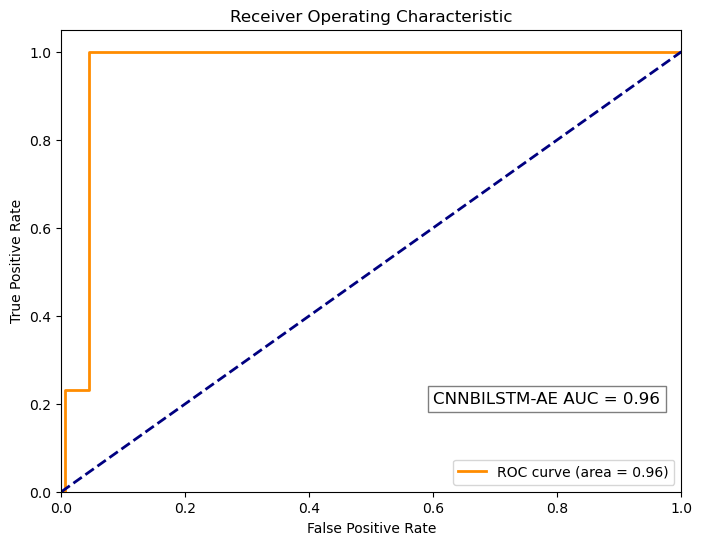

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC Curve 분석
fpr, tpr, thresholds = roc_curve(y, losses)
roc_auc = auc(fpr, tpr)

# ROC Curve 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# AUC 값 그래프에 표시
plt.text(0.6, 0.2, f"CNN-BiLSTM-AE AUC = {roc_auc:.2f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

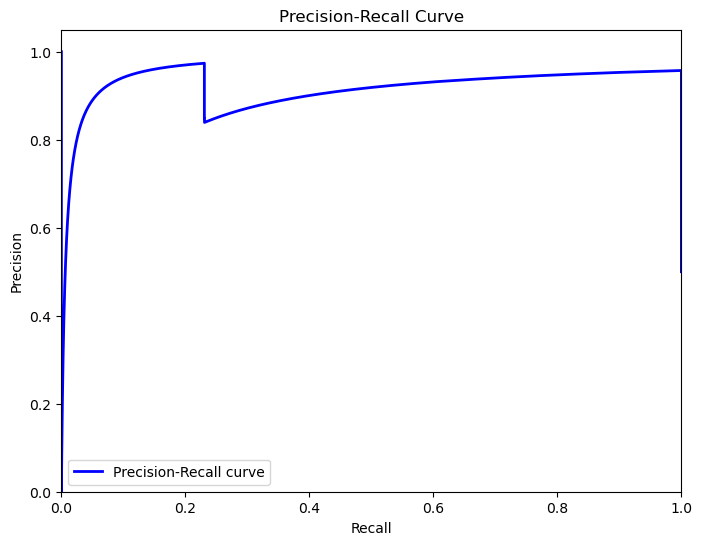

In [161]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve 분석
precision, recall, thresholds = precision_recall_curve(y, losses)

# Precision-Recall Curve 그리기
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()
